In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import time
import os

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

from gudhi import AlphaComplex, SimplexTree
from src.depth import DepthPoset

from tqdm.notebook import tqdm

# Depth Posets List

I'll create just few random Alpha Complexes, abd generate Depth Poset from them.

In [3]:
ndim_pairs = np.array([(8, 1), (16, 1), (32, 1), 
                       (8, 2), (16, 2), (32, 2), 
                       (8, 3), (16, 3), (32, 3), 
                      ])

In [4]:
directory = "results"
path = f'{directory}/depth-generation-times.pkl'

In [5]:
try:
    with open(path, "rb") as file:
        depth_posets = pkl.load(file)
    try:
        if (np.array([cloud.shape for cloud in depth_posets['cloud']]) != ndim_pairs).any():
            raise FileNotFoundError
    except ValueError:
        raise FileNotFoundError
    print('Data is loaded.')

except FileNotFoundError:
    depth_posets = []
    with tqdm(total=len(ndim_pairs)) as pbar:
        for n, dim in ndim_pairs:
            pbar.set_postfix_str(f'n={n}, dim={dim}')
            pbar.refresh()
            points = np.random.random(size=[n, dim])
            # generating SimplexTree
            timer_stree = time.perf_counter()
            stree = AlphaComplex(points).create_simplex_tree()
            timer_stree = time.perf_counter() - timer_stree
            # generating DepthPoset
            timer_depth = time.perf_counter()
            depth_poset = DepthPoset.from_simplex_tree(stree)
            timer_depth = time.perf_counter() - timer_depth
            
            depth_posets.append({'name': f'Alpha Complex {n} points dim {dim}', 
                                 'depth poset': depth_poset, 
                                 'cloud': points.copy(), 
                                 'stree time': timer_stree, 
                                 'depth time': timer_depth, 
                                 'dim': dim, 
                                 'n': n, 
                                })
            pbar.update()
    
    depth_posets = pd.DataFrame(depth_posets)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(path, "wb") as file:
        pkl.dump(depth_posets, file)
        
    print('Data is generated and saved.')

print(f'depth_posets.shape = {depth_posets.shape}')
depth_posets.head()

  0%|          | 0/9 [00:00<?, ?it/s]

Data is generated and saved.
depth_posets.shape = (9, 7)


,name,depth poset,cloud,stree time,depth time,dim,n
0,Alpha Complex 8 points dim 1,<src.depth.DepthPoset object at 0x76ba4b5721e0>,"[[0.6513139695466182], [0.11531556918132968], ...",0.000361,0.003953,1,8
1,Alpha Complex 16 points dim 1,<src.depth.DepthPoset object at 0x76b9e11f1430>,"[[0.033387997615154985], [0.5220029700285159],...",0.000169,0.006563,1,16
2,Alpha Complex 32 points dim 1,<src.depth.DepthPoset object at 0x76b9e170a540>,"[[0.3519264468039651], [0.834430416467096], [0...",0.000328,0.011953,1,32
3,Alpha Complex 8 points dim 2,<src.depth.DepthPoset object at 0x76b9e11f2840>,"[[0.9645261183481637, 0.0606945427697253], [0....",0.000289,0.003937,2,8
4,Alpha Complex 16 points dim 2,<src.depth.DepthPoset object at 0x76b9e11f2e40>,"[[0.9618203864998072, 0.8630106039467094], [0....",0.000409,0.011488,2,16


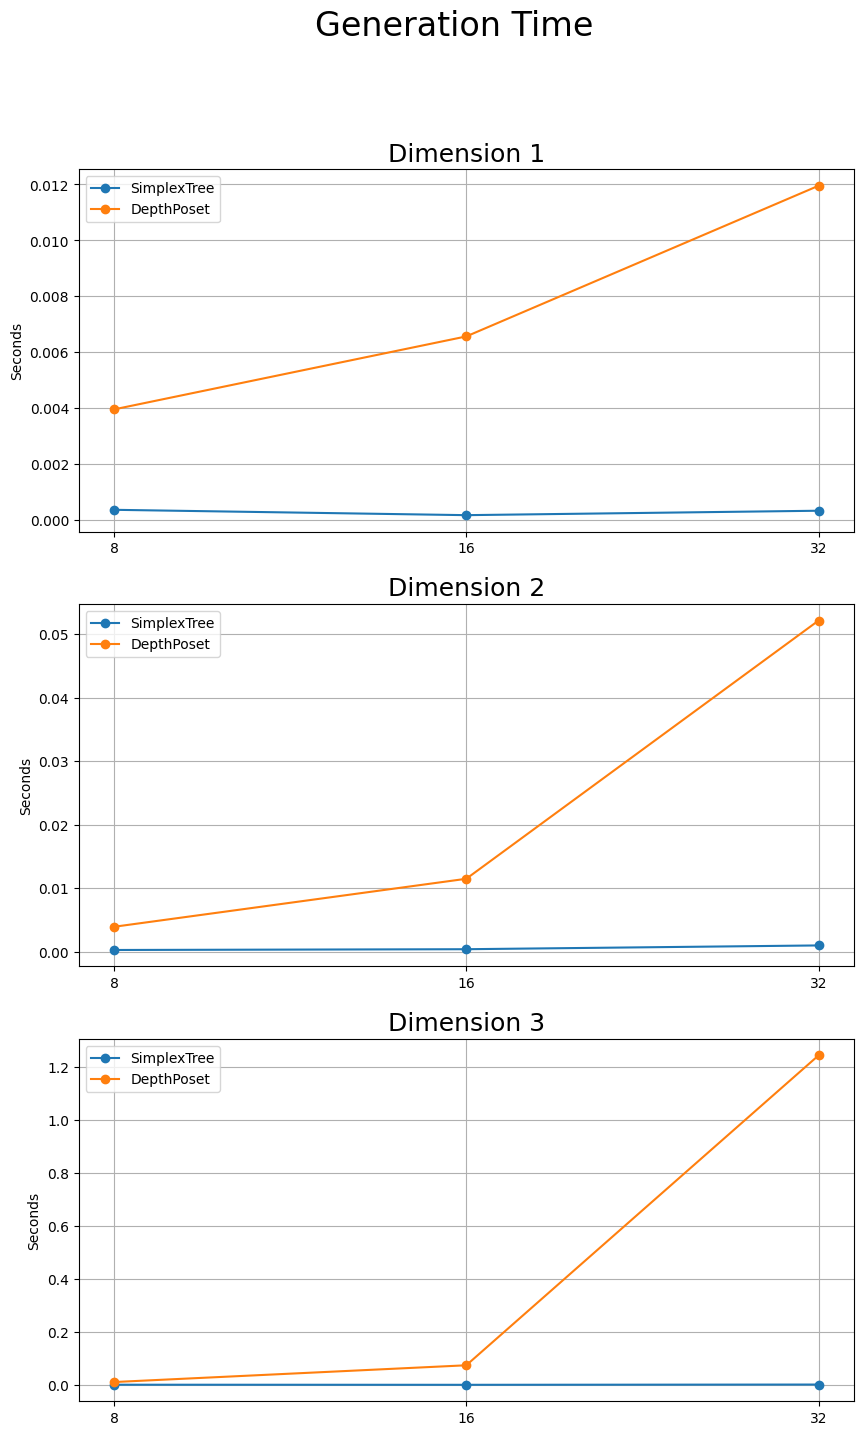

In [6]:
dims = pd.unique(depth_posets['dim'])

fig, axs = plt.subplots(len(dims))
fig.set_figheight(16)
fig.set_figwidth(10)
fig.suptitle('Generation Time', fontsize=24)


for idim, dim in enumerate(dims):
    idf = depth_posets[depth_posets['dim'] == dim].sort_values('n')
    axs[idim].set_title(f'Dimension {dim}', fontsize=18)
    axs[idim].plot(np.log(idf['n']), idf['stree time'], marker='o', label='SimplexTree')
    axs[idim].plot(np.log(idf['n']), idf['depth time'], marker='o', label='DepthPoset')
    
    axs[idim].set_xticks(np.log(pd.unique(depth_posets['n'])), labels=pd.unique(depth_posets['n']))
    #axs[idim].set_xlabel('$n$')
    axs[idim].set_ylabel('Seconds')
    axs[idim].grid(True)
    axs[idim].legend()

# Poset Scores on Depth Posets

In [7]:
from src import poset_scores

In [8]:
poset_scores_to_check = [
    poset_scores.number_of_nodes, 
    poset_scores.number_of_minimal_nodes, 
    poset_scores.number_of_maximal_nodes, 
    poset_scores.height, 
    poset_scores.width, 
    poset_scores.minimum_maximal_chain, 
    poset_scores.avarage_maximal_chain, 
]

In [9]:
directory = "results"
path = f'{directory}/depth-poset-scores-times.pkl'

In [10]:
try:
    with open(path, "rb") as file:
        poset_score_times = pkl.load(file)
    
    score_names = [score.__name__ for score in poset_scores_to_check]
    if list(poset_score_times.columns[poset_score_times.columns.str.contains('time')].str.replace(' time', '').values) != score_names:
        raise FileNotFoundError
    if list(poset_score_times.columns[poset_score_times.columns.str.contains('value')].str.replace(' value', '').values) != score_names:
        raise FileNotFoundError
    if list(pd.unique(poset_score_times['name'])) != list(pd.unique(depth_posets['name'])):
        raise FileNotFoundError
    
    print('Data is loaded.')

except FileNotFoundError:
    poset_score_times = []
    with tqdm(total=len(depth_posets)) as pbar:
        for irow, row in depth_posets.iterrows():
            # scores for full poset
            name = row['name']
            poset = row['depth poset']
    
            newrow = {'name': name, 
                      'subposet dim': None}
            for score in poset_scores_to_check:
                pbar.set_postfix_str(f'Full poset, score={score.__name__}')
                pbar.refresh
                timer = time.perf_counter()
                value = score(poset)
                timer = time.perf_counter() - timer
                newrow.update({f'{score.__name__} value': value, 
                               f'{score.__name__} time': timer,
                              })
            poset_score_times.append(newrow)
            
            # scores for subposets of given dimensions
            for dim in range(poset.get_dim() + 1):
                newrow = {'name': name, 
                          'subposet dim': dim}
                subposet = poset.subposet_dim(dim)
                for score in poset_scores_to_check:
                    pbar.set_postfix_str(f'Subposet dim={dim}, score={score.__name__}')
                    pbar.refresh
                    timer = time.perf_counter()
                    value = score(subposet)
                    timer = time.perf_counter() - timer
                    newrow.update({f'{score.__name__} value': value, 
                                   f'{score.__name__} time': timer,
                                  })
                poset_score_times.append(newrow)
            pbar.update()

    poset_score_times = pd.DataFrame(poset_score_times)
    
    if not os.path.exists(directory):
        os.makedirs(directory)    
    with open(path, "wb") as file:
        pkl.dump(poset_score_times, file)
    print('Data is generated and saved.')

print(f'poset_score_times.shape = {poset_score_times.shape}')

  0%|          | 0/9 [00:00<?, ?it/s]

Data is generated and saved.
poset_score_times.shape = (27, 16)


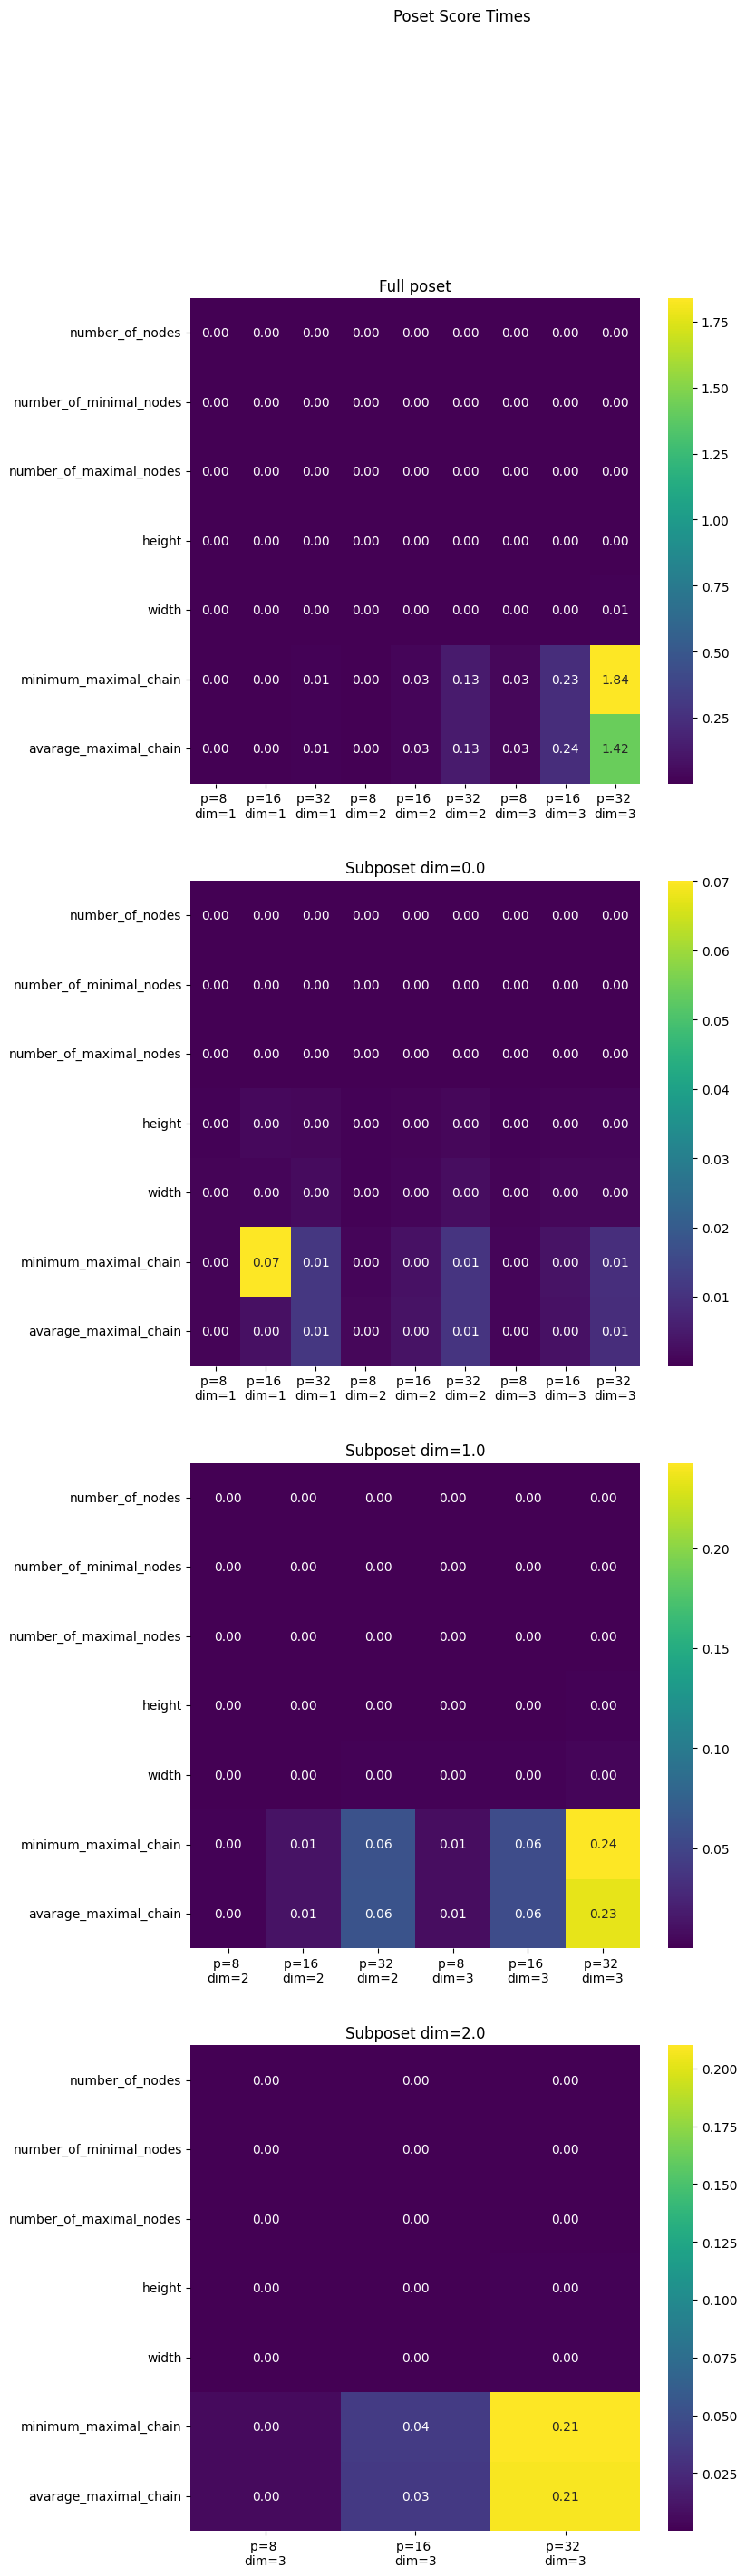

In [11]:
dims = pd.unique(poset_score_times['subposet dim'])

fig, axs = plt.subplots(len(dims))
fig.set_figheight(32)
fig.set_figwidth(8)
fig.suptitle("Poset Score Times")

for idim, dim in enumerate(dims):
    if pd.isna(dim):
        df = poset_score_times[poset_score_times['subposet dim'].isna()]
        title = 'Full poset'
    else:
        df = poset_score_times[poset_score_times['subposet dim'] == dim]
        title = f'Subposet dim={dim}'
    axs[idim].set_title(title)
    df = df[np.append('name', df.columns[df.columns.str.contains('time')])]
    df.columns = df.columns.str.replace(' time', '')
    df = df.set_index('name')
    df.index.name = None
    df.index = df.index.str.replace('Alpha Complex ', 'p=').str.replace('points dim ', '\ndim=')
    df = df.transpose()
    sns.heatmap(df, ax=axs[idim], cmap='viridis', annot=True, fmt=".2f")

# Node Scores on Depth Posets

In [12]:
from src import node_scores

In [13]:
node_scores_to_check = [
    node_scores.incomparable_number, 
    node_scores.incestors_number, 
    node_scores.incestors_height, 
    node_scores.incestors_width, 
    node_scores.successors_number, 
    node_scores.successors_height, 
    node_scores.successors_width, 
]

In [14]:
directory = "results"
path = f'{directory}/depth-node-scores-times.pkl'

In [15]:
try:
    with open(path, "rb") as file:
        node_score_times = pkl.load(file)

    score_names = [score.__name__ for score in node_scores_to_check]
    cols_time = node_score_times.columns[node_score_times.columns.str.contains('time')].str.replace(' time', '')
    
    if not np.array([(score_name in cols_time) for score_name in score_names]).all():
        raise FileNotFoundError
    cols_value = node_score_times.columns[node_score_times.columns.str.endswith('value')].str.replace(' value', '')
    if not np.array([score_name in cols_value for score_name in score_names]).all():
        raise FileNotFoundError

    if list(np.unique(node_score_times['name'].values)) != list(np.unique(depth_posets['name'])):
        raise FileNotFoundError
    
    print('Data is loaded.')


except FileNotFoundError:
    check_nodes_number = 4
    
    node_score_times = []
    with tqdm(total=len(depth_posets)) as pbar:
        for irow, row in depth_posets.iterrows():
            # scores for full poset
            name = row['name']
            poset = row['depth poset']
            nodes_to_check = np.random.choice(poset.nodes, min(len(poset.nodes), check_nodes_number), replace=False)
            for inode, node in enumerate(nodes_to_check):
                newrow = {'name': name, 
                          'subposet dim': None, 
                          'node': node
                         }
                for score in node_scores_to_check:
                    pbar.set_postfix_str(f'Full poset, node={inode}/{len(poset.nodes)}, score={score.__name__}')
                    pbar.refresh
                    timer = time.perf_counter()
                    value = score(poset, node)
                    timer = time.perf_counter() - timer
                    newrow.update({f'{score.__name__} value': value, 
                                   f'{score.__name__} time': timer,
                                  })
                    node_score_times.append(newrow)
            
            # scores for subposets of given dimensions
            for dim in range(poset.get_dim() + 1):
                subposet = poset.subposet_dim(dim)
                nodes_to_check = np.random.choice(subposet.nodes, min(len(subposet.nodes), check_nodes_number), replace=False)
                for inode, node in enumerate(nodes_to_check):
                    newrow = {'name': name, 
                              'subposet dim': dim, 
                              'node': node}
                    for score in node_scores_to_check:
                        pbar.set_postfix_str(f'Subposet dim={dim}, node={inode}/{len(subposet.nodes)}, score={score.__name__}')
                        pbar.refresh
                        timer = time.perf_counter()
                        value = score(subposet, node)
                        timer = time.perf_counter() - timer
                        newrow.update({f'{score.__name__} value': value, 
                                       f'{score.__name__} time': timer,
                                      })
                    node_score_times.append(newrow)
            pbar.update()

    node_score_times = pd.DataFrame(node_score_times)
    
    if not os.path.exists(directory):
        os.makedirs(directory)    
    with open(path, "wb") as file:
        pkl.dump(node_score_times, file)
    print('Data is generated and saved.')

print(f'node_score_times.shape = {node_score_times.shape}')

  0%|          | 0/9 [00:00<?, ?it/s]

Data is generated and saved.
node_score_times.shape = (324, 17)


In [16]:
if False:
    node_score_times = pd.DataFrame(node_score_times)
    
    if not os.path.exists(directory):
        os.makedirs(directory)    
    with open(path, "wb") as file:
        pkl.dump(node_score_times, file)
    print('Data is generated and saved.')

print(f'node_score_times.shape = {node_score_times.shape}')

node_score_times.shape = (324, 17)


In [17]:
node_score_times_g = node_score_times[np.concatenate([['name', 'subposet dim'], node_score_times.columns[node_score_times.columns.str.contains('time')]])]
node_score_times_g.columns = node_score_times_g.columns.str.replace(' time', '')
node_score_times_g.loc[node_score_times_g['subposet dim'].isna(), 'subposet dim'] = 'full'

node_score_times_g = node_score_times_g.groupby(['name', 'subposet dim'])

aggs = ['mean', 'max', 'sum']



/tmp/ipykernel_255177/2017678387.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'full' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  node_score_times_g.loc[node_score_times_g['subposet dim'].isna(), 'subposet dim'] = 'full'


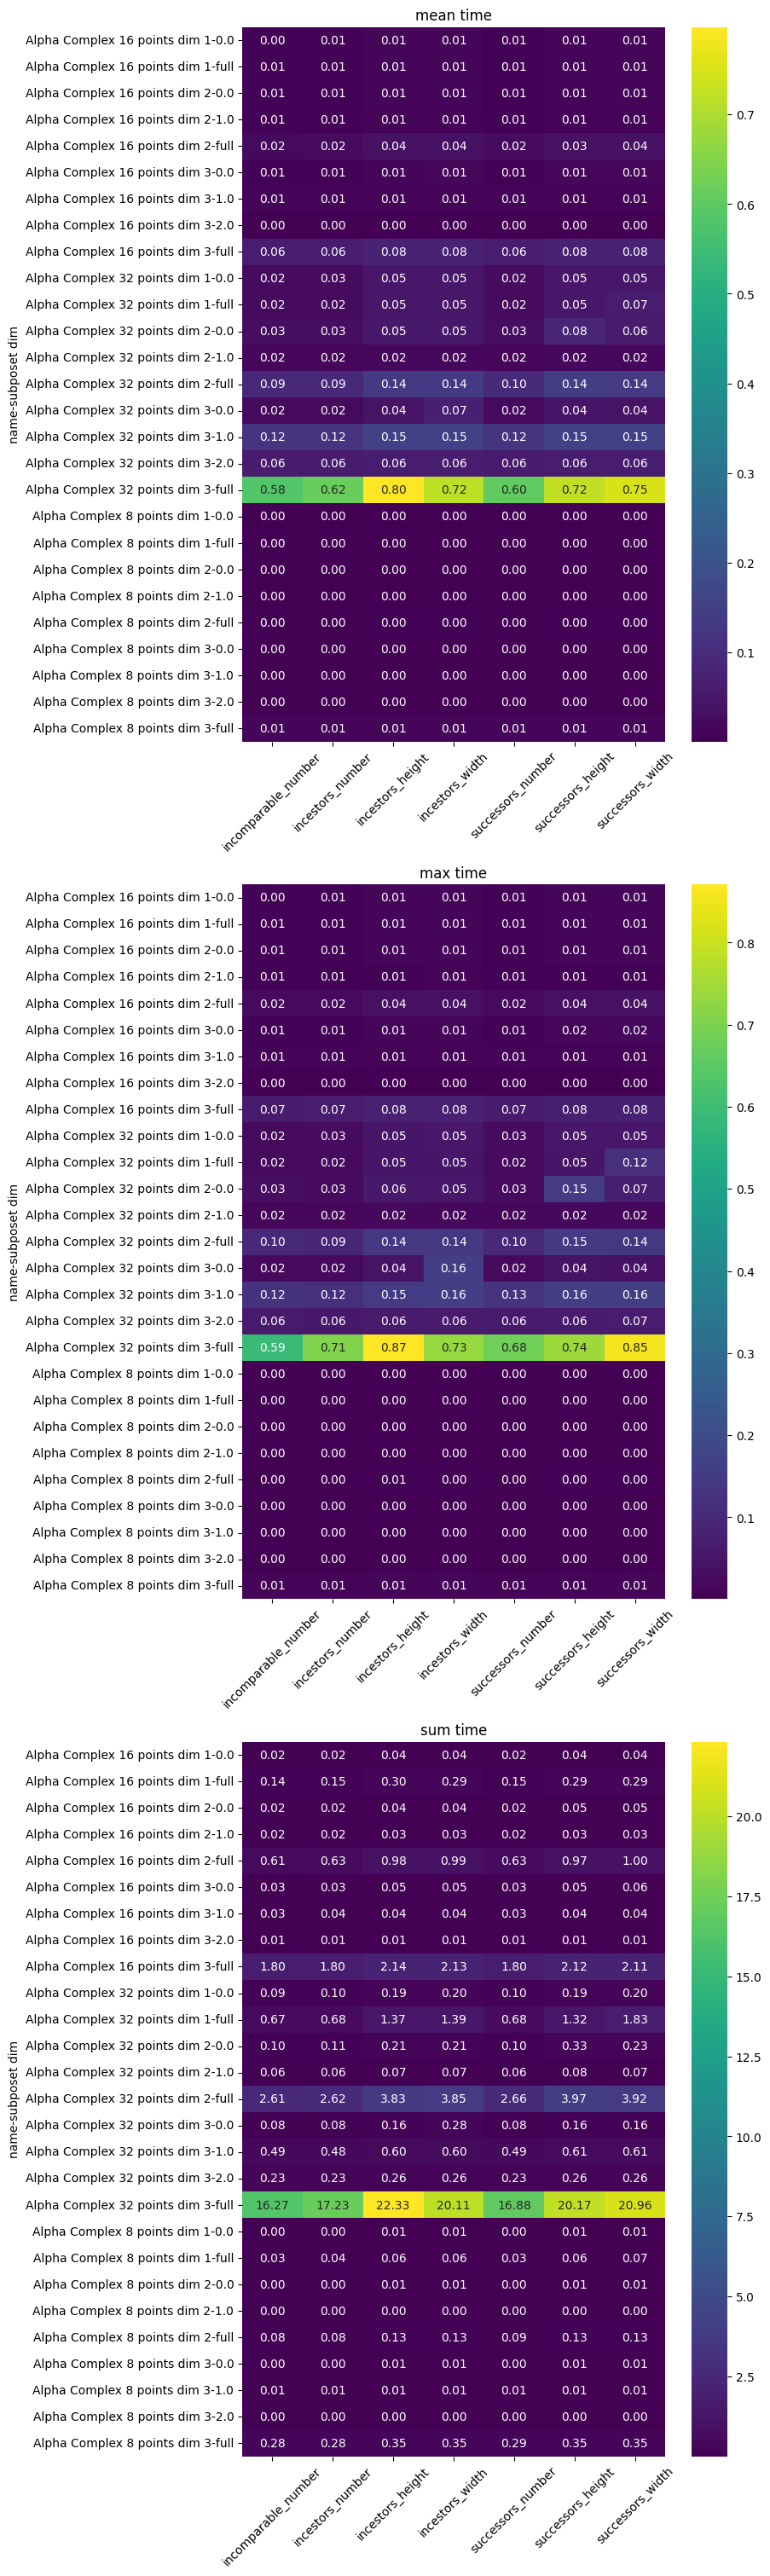

In [18]:
fig, axs = plt.subplots(len(aggs))
fig.set_figwidth(8)
fig.set_figheight(12*len(aggs) + 1)

for iagg, agg in enumerate(aggs):
    axs[iagg].set_title(f'{agg} time')
    g = sns.heatmap(node_score_times_g.aggregate(agg), ax=axs[iagg], cmap='viridis', annot=True, fmt=".2f")
    g.set_xticklabels(g.get_xticklabels(), rotation=45)